<a href="https://colab.research.google.com/github/sergejhorvat/Tensorflow2.0_Udemy/blob/master/Creating_Image_classification_API_with_TensorFlow_Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stage 1: Install dependencies and setting up GPU environment

In [1]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  19885      0 --:--:-- --:--:-- --:--:-- 19885
OK


In [2]:
# Did not update properly, had issue with line !tail server.log
#!apt-get update & apt-get install tensorflow-model-server

# Alternative update procedure
!apt-get install tensorflow-model-server
# Command returned response that it installed new package:
#The following NEW packages will be installed:
#  tensorflow-model-server
# 0 upgraded, 1 newly installed, 0 to remove and 128 not upgraded.

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (1.14.0).
0 upgraded, 0 newly installed, 0 to remove and 128 not upgraded.


In [5]:
# TF 2.0 does not have great support for TF Serving yet!
!pip install tensorflow-gpu==1.13.1

In [6]:
!pip install requests

## Stage 2: Import project dependencies

In [7]:
import os
import json
import random
import requests

# Would not be realy used in this tutorial
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

# Tell matplot lib that all visualization should be kept inside of it
%matplotlib inline
tf.__version__

'1.13.1'

## Stage 3: Dataset preprocessing

### Loading the dataset

In [8]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [0]:
# Class names can be found on CIFAR10 main page https://www.cs.toronto.edu/~kriz/cifar.html
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Image normalization

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
X_train.shape

(50000, 32, 32, 3)

Check the training data if it's normalized.

In [12]:
# Take one image of size 32x32 pixels nad RGB chanells
X_train[1]

array([[[0.60392157, 0.69411765, 0.73333333],
        [0.49411765, 0.5372549 , 0.53333333],
        [0.41176471, 0.40784314, 0.37254902],
        ...,
        [0.35686275, 0.37254902, 0.27843137],
        [0.34117647, 0.35294118, 0.27843137],
        [0.30980392, 0.31764706, 0.2745098 ]],

       [[0.54901961, 0.62745098, 0.6627451 ],
        [0.56862745, 0.6       , 0.60392157],
        [0.49019608, 0.49019608, 0.4627451 ],
        ...,
        [0.37647059, 0.38823529, 0.30588235],
        [0.30196078, 0.31372549, 0.24313725],
        [0.27843137, 0.28627451, 0.23921569]],

       [[0.54901961, 0.60784314, 0.64313725],
        [0.54509804, 0.57254902, 0.58431373],
        [0.45098039, 0.45098039, 0.43921569],
        ...,
        [0.30980392, 0.32156863, 0.25098039],
        [0.26666667, 0.2745098 , 0.21568627],
        [0.2627451 , 0.27058824, 0.21568627]],

       ...,

       [[0.68627451, 0.65490196, 0.65098039],
        [0.61176471, 0.60392157, 0.62745098],
        [0.60392157, 0

## Stage 4: Defining the model

NOTE: We are using the model from the Section for Convolutional neural networks

In [13]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


### Compiling the model

In [0]:
model.compile(optimizer='Adam',
              # sparce_* is alternative for expensive one-hot class encoding methodology
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

### Training the model

In [15]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=10)

Epoch 1/10
50000/50000 [==============================] - 12s 245us/sample - loss: 1.4477 - sparse_categorical_accuracy: 0.4820
Epoch 2/10
50000/50000 [==============================] - 11s 217us/sample - loss: 1.0213 - sparse_categorical_accuracy: 0.6431
Epoch 3/10
50000/50000 [==============================] - 11s 218us/sample - loss: 0.8432 - sparse_categorical_accuracy: 0.7073
Epoch 4/10
50000/50000 [==============================] - 11s 217us/sample - loss: 0.7252 - sparse_categorical_accuracy: 0.7479
Epoch 5/10
50000/50000 [==============================] - 11s 216us/sample - loss: 0.6293 - sparse_categorical_accuracy: 0.7804
Epoch 6/10
50000/50000 [==============================] - 11s 217us/sample - loss: 0.5436 - sparse_categorical_accuracy: 0.8102
Epoch 7/10
50000/50000 [==============================] - 11s 219us/sample - loss: 0.4614 - sparse_categorical_accuracy: 0.8378
Epoch 8/10
50000/50000 [==============================] - 11s 218us/sample - loss: 0.3855 - sparse_categ

### Model evaluation

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 171us/sample - loss: 0.9525 - sparse_categorical_accuracy: 0.7427


In [17]:
print("Test accuracy is {}".format(test_accuracy))

Test accuracy is 0.7426999807357788


## Stage 5: Saving the model for production

### Creating the directory for the model

In [0]:
MODEL_DIR = "model/"
version = 1

In [19]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [0]:
# Ensure that path of model does not exists
if os.path.isdir(export_path):
  # bash to delete it rm(remove) -r(recursevly)
    !rm -r {export_path}

### Saving the model for the TensorFlow Serving

For serving model in production additional informations are needed:


*   Input to a model
*   Outputs from model
*   Location of the model


Returns the TF session to be used by the backend:

`tf.keras.backend.get_session()` 


Path to the model:

`export_dir=export_path`



Model needs to map model parts to individual keys:

`inputs={"input_image":model.input}`


Model can have multiple outputs, we will use dictionary comprihantion method.

`outputs={t.name:t for t in model.outputs}`

In [21]:
tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model/1/saved_model.pb


Model directory and files have been created for serving. They can be found under files in model directory.

## Stage 6: Setting up the production environment

### Exporting the MODEL_DIR to environment variables

To serve it's needed to load the model and return inferentials.

Environmental variables need to be setup, so the path can be accessed from anywhere from system. So TFS can easili can find it.

In [0]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

### Running the TensorFlow Serving REST API

`%%bash` - to enter terminal mode of system

  `-bg` run it in background
  
`nohup` - any command that follows it should be executed in the background as a service. So we can still interact with the notebook and command will kepp runin whole model structure in separate thread.

`tensorflow_model_server` - TFS application to serve the model

`--rest_api_port=8510`  - define a port for REST API serving of a model

`--model_name=cifar10`  - custom name for this model , it will be reference

`--model_base_path="${MODEL_DIR}"` - our environmental variable for model path 

`>server,log 2>&1` - create logging for the server

In [23]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8501 --model_name=cifar10 --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


To see the last lines from log file use system `tail` command. It will be last 10 lines, Refresh command to update. 

In [26]:
!tail server.log

2019-09-30 08:57:15.842674: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2019-09-30 08:57:15.845862: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-09-30 08:57:15.865790: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-09-30 08:57:15.902994: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 63626 microseconds.
2019-09-30 08:57:15.903054: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:103] No warmup data file found at /content/model/1/assets.extra/tf_serving_warmup_requests
2019-09-30 08:57:15.903130: I tensorflow_serving/core/loader_harness.cc:86] Successfully loaded servable version {name: cifar10 version: 1}
2019-09-30 08:57:15.904673: I tensorflow_serving/

## Stage 7: Creating the first POST request

In [25]:
random_image = np.random.randint(0, len(X_test))
random_image

6279

### Creating the JSON data object

Transformation from Python (numpy) objects needs to be done to json objects so the information can be passed trought internet. (Boxing/Unboxing, serialization, marshaling/demarshaling).

`json.dumps` - functio taked Python distionary and creates json object from it.

`{"signature_name":"serving_default"}` - tag for TensorFlow Serving, it is needed to provide as a default configuration for TFS library.


`"instances":[X_test[random_image].tolist()]}` - provide image list that we will sent to server. We are sending one random_image.

Transformation from Python (numpy) objects needs to be done to json objects so the information can be passed trought internet. (Boxing/Unboxing).


In [0]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [28]:
data

'{"signature_name": "serving_default", "instances": [[[[0.7098039215686275, 0.7411764705882353, 0.6627450980392157], [0.2627450980392157, 0.2627450980392157, 0.23137254901960785], [0.16470588235294117, 0.1568627450980392, 0.13333333333333333], [0.17254901960784313, 0.16470588235294117, 0.12941176470588237], [0.16862745098039217, 0.1568627450980392, 0.11764705882352941], [0.16862745098039217, 0.1607843137254902, 0.11372549019607843], [0.7019607843137254, 0.7176470588235294, 0.6274509803921569], [0.8313725490196079, 0.8588235294117647, 0.7450980392156863], [0.8470588235294118, 0.8627450980392157, 0.7647058823529411], [0.8509803921568627, 0.8666666666666667, 0.7686274509803922], [0.8509803921568627, 0.8666666666666667, 0.7686274509803922], [0.8549019607843137, 0.8705882352941177, 0.7725490196078432], [0.8666666666666667, 0.8823529411764706, 0.7843137254901961], [0.8666666666666667, 0.8823529411764706, 0.7803921568627451], [0.8627450980392157, 0.8823529411764706, 0.7647058823529411], [0.86

### Sending the first POST request to the model

HTTP Header should be creted and format that is used JSON in our case.

In [0]:
headers = {"content-type":"application/json"}

HTTP POST request creation part for calling inference on our serverd model with proper request path.


POST url for our model:
```
url="http://localhost:8501/v1/models/cifar10:predict"
```


Json data object that we created in previous step that contains image coded in json:
```
data=data
```


Our defined header for Json format:
```
headers=headers
```

In [0]:
json_response = requests.post(url="http://localhost:8501/v1/models/cifar10:predict", data=data, headers=headers)

Receiving HTTP status code, to see prediction need to unbox json data.

In [31]:
json_response

<Response [200]>

Unbox the data from json response object:

In [0]:
predictions = json.loads(json_response.text)['predictions']

Get the response from prediction function from model. 
This are prediction probabilities for every class (10 classes). The biggest probability is our predicted class.

In [33]:
predictions

[[6.81481455e-13,
  1.0,
  5.59599381e-20,
  4.88164023e-12,
  1.48372511e-19,
  1.45581789e-16,
  8.03010845e-16,
  3.58490093e-20,
  6.77076396e-13,
  2.4256801e-08]]

Visualize send image

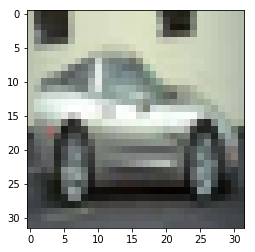

In [34]:
plt.imshow(X_test[random_image])

Get the class name from class list.

`np.argmax(predictions[0])` - take the top rated prediction probability (sorted) class and show from classes dictionary string that describes it.

In [35]:
class_names[np.argmax(predictions[0])]

'automobile'

## Stage 8: Sending the POST request to a specific model

In [0]:
specific_json_response = requests.post(url="http://localhost:8501/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [0]:
specific_json_response

<Response [200]>